In [3]:
import networkx as nx
import pandas as pd
import SimpleITK as sitk

In [4]:
import cv2
import math
import scipy
import skimage

import numpy as np

from numba import jit
from scipy import signal, sparse, stats
from skimage.morphology._util import _raveled_offsets_and_distances
from skimage.util._map_array import map_array
from skimage.graph._graph import _weighted_abs_diff
from sklearn.cluster import KMeans,AgglomerativeClustering  # USAR EL DE RAPIDS
from typing import Optional, Callable
from skimage import measure
from sklearn.feature_extraction.image import grid_to_graph

In [6]:
metrics_fluid_slice = pd.DataFrame(
    columns = ['manufacturer', 'case', 'slice', 'w_gt', 'dice', 'acc', 'sens', 'prec', 'fraction', 'fluids']
)

metrics_fluid =  metrics_fluid_slice.copy()

def line_metrics(manufacturer, case, i, ref, seg, vol=False):
    ref_neg = np.abs(ref-1)
    seg_neg = np.abs(seg-1)
    fluids = len(np.unique(ref_neg))
    if vol:
        return {
            'manufacturer': manufacturer,
            'case': case,
            'w_gt': ref.any(),
            'slice': i,
            'dice': np.sum(seg[ref==1])*2.0 / (np.sum(ref) + np.sum(seg)),
            'acc': (np.sum(seg[ref==1]) + np.sum(seg_neg[ref_neg==1])) / (ref.shape[0]*ref.shape[1]*ref.shape[2]), 
            'sens': np.sum(seg[ref==1]) / np.sum(ref), 
            'spec': np.sum(seg_neg[ref_neg==1]) / np.sum(ref_neg),
            'prec': np.sum(seg[ref==1]) / np.sum(seg),
            'fraction': np.sum(ref) / (ref.shape[0]*ref.shape[1]*ref.shape[2]),
            'fluids': fluids
        }
    return {
        'manufacturer': manufacturer,
        'case': case,
        'w_gt': ref.any(),
        'slice': i,
        'dice': np.sum(seg[ref==1])*2.0 / (np.sum(ref) + np.sum(seg)),
        'acc': (np.sum(seg[ref==1]) + np.sum(seg_neg[ref_neg==1])) / (ref.shape[0]*ref.shape[1]), 
        'sens': np.sum(seg[ref==1]) / np.sum(ref), 
        'spec': np.sum(seg_neg[ref_neg==1]) / np.sum(ref_neg),
        'prec': np.sum(seg[ref==1]) / np.sum(seg),
        'fraction': np.sum(ref) / (ref.shape[0]*ref.shape[1]),
        'fluids': fluids
    }
    

import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith("segmentation_.mhd"):
            manufacturer = root.split('/')[-2]
            manufacturer = manufacturer.split('-')[-1]
            case = root.split('/')[-1]
            
            print(manufacturer, case, file)
            
            segm_mhd = os.path.join(root, file)
            ref_mhd = os.path.join(root, 'reference.mhd')
            
            seg_itk = sitk.ReadImage(segm_mhd)
            ref_itk = sitk.ReadImage(ref_mhd)
            seg_vol = sitk.GetArrayFromImage(seg_itk)
            ref_vol = sitk.GetArrayFromImage(ref_itk)
            
            # Metrics all fluids
            ref_vol = np.where(ref_vol!=0,1,0)
            for i in range(ref_vol.shape[0]):
                row = line_metrics(manufacturer, case, i, ref_vol[i,...], seg_vol[i,...])
                metrics_fluid_slice = metrics_fluid_slice.append(row, ignore_index=True)
                metrics_fluid_slice.to_csv('/dices_all_slice_fluid.csv')
            row = line_metrics(manufacturer, case, i, ref_vol, seg_vol, vol=True)
            metrics_fluid = metrics_fluid.append(row, ignore_index=True)
            metrics_fluid.to_csv('../dices_all_fluid.csv')
            
#             # Metrics IRF
#             seg_vol = sitk.GetArrayFromImage(seg_itk)
#             ref_vol = sitk.GetArrayFromImage(ref_itk)
#             ref_vol = np.where(ref_vol!=1, 0, 1)
#             for i in range(ref_vol.shape[0]):
#                 row = line_metrics(manufacturer, case, i, ref_vol[i,...], seg_vol[i,...])
#                 metrics_fluid_slice = metrics_fluid_slice.append(row, ignore_index=True)
#                 metrics_fluid_slice.to_csv('../dices_all_slice_fluid_IRF.csv')
#             row = line_metrics(manufacturer, case, i, ref_vol, seg_vol)
#             metrics_fluid = metrics_fluid.append(row, ignore_index=True)
#             metrics_fluid.to_csv('../dices_all_fluid_IRF.csv')
            
#             # Metrics SRF
#             seg_vol = sitk.GetArrayFromImage(seg_itk)
#             ref_vol = sitk.GetArrayFromImage(ref_itk)
#             ref_vol = np.where(ref_vol!=2, 0, 1)
#             for i in range(ref_vol.shape[0]):
#                 row = line_metrics(manufacturer, case, i, ref_vol[i,...], seg_vol[i,...])
#                 metrics_fluid_slice = metrics_fluid_slice.append(row, ignore_index=True)
#                 metrics_fluid_slice.to_csv('../dices_all_slice_fluid_SRF.csv')
#             row = line_metrics(manufacturer, case, i, ref_vol, seg_vol)
#             metrics_fluid = metrics_fluid.append(row, ignore_index=True)
#             metrics_fluid.to_csv('../dices_all_fluid_SRF.csv')
            
#             # Metrics PED
#             seg_vol = sitk.GetArrayFromImage(seg_itk)
#             ref_vol = sitk.GetArrayFromImage(ref_itk)
#             ref_vol = np.where(ref_vol!=3, 0, 1)
#             for i in range(ref_vol.shape[0]):
#                 row = line_metrics(manufacturer, case, i, ref_vol[i,...], seg_vol[i,...])
#                 metrics_fluid_slice = metrics_fluid_slice.append(row, ignore_index=True)
#                 metrics_fluid_slice.to_csv('../dices_all_slice_PED.csv')
#             row = line_metrics(manufacturer, case, i, ref_vol, seg_vol)
#             metrics_fluid = metrics_fluid.append(row, ignore_index=True)
#             metrics_fluid.to_csv('../dices_all_fluid_PED.csv')

Spectralis TRAIN044 segmentation_.mhd


/home/joaquin/anaconda3/envs/improject/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars
/home/joaquin/anaconda3/envs/improject/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


Spectralis TRAIN031 segmentation_.mhd


/home/joaquin/anaconda3/envs/improject/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


Spectralis TRAIN025 segmentation_.mhd


In [7]:
metrics_fluid

,manufacturer,case,slice,w_gt,dice,acc,sens,prec,fraction,fluids,spec
0,Spectralis,TRAIN044,48,True,0.629359,0.977670,0.476632,0.926111,0.039776,2,0.998425
1,Spectralis,TRAIN031,48,True,0.000000,0.995311,0.000000,0.000000,0.003420,2,0.998727
2,Spectralis,TRAIN025,48,True,0.439424,0.989507,0.318768,0.707046,0.012902,2,0.998274


In [1]:
import pandas as pd
metrics_fluid = pd.read_csv('../dices_all_fluid.csv')

In [2]:
metrics_fluid.loc[metrics_fluid.manufacturer == 'Spectralis']

,Unnamed: 0,manufacturer,case,slice,w_gt,dice,acc,sens,prec,fraction,fluids,spec
0,0,Spectralis,TRAIN032,48,True,0.429934,484.210747,0.448882,0.412521,23.344882,2,0.969460
1,1,Spectralis,TRAIN046,48,True,0.075262,500.021437,0.047705,0.178199,10.218030,2,0.995520
2,2,Spectralis,TRAIN027,48,True,0.473946,501.552872,0.571436,0.404872,8.235640,2,0.986268
3,3,Spectralis,TRAIN038,48,True,0.455520,497.619281,0.448872,0.462368,13.401498,2,0.985971
4,4,Spectralis,TRAIN035,48,True,0.601992,499.842865,0.557081,0.654780,16.503744,2,0.990217
5,5,Spectralis,TRAIN044,48,True,0.582109,498.380925,0.465767,0.775925,20.365290,2,0.994428
6,6,Spectralis,TRAIN039,48,True,0.378865,503.374465,0.541933,0.291233,4.854098,2,0.987376
7,7,Spectralis,TRAIN033,48,True,0.293609,504.893598,0.217416,0.452020,6.792874,2,0.996456
8,8,Spectralis,TRAIN048,48,True,0.183703,500.592330,0.495733,0.112741,2.589327,2,0.980169
9,9,Spectralis,TRAIN028,48,True,0.071738,507.668367,0.106842,0.053997,1.566615,2,0.994255


In [57]:
results = pd.DataFrame(columns=['Spectralis','Cirrus', 'Topcon'],
             index=['mean_dice', 'std_dice', 'mean_sens', 'std_sens', 'mean_spec', 'std_spec'])

In [58]:
for i in ['Spectralis','Cirrus', 'Topcon']:
    for j in ['dice','sens', 'spec']:
        results.loc[f'mean_{j}', i] = metrics_fluid.loc[metrics_fluid.manufacturer == i, j].mean()
        results.loc[f'std_{j}', i] = metrics_fluid.loc[metrics_fluid.manufacturer == i, j].std()

In [59]:
results

,Spectralis,Cirrus,Topcon
mean_dice,0.278205,0.20326,0.129316
std_dice,0.180801,0.165255,0.098525
mean_sens,0.400727,0.630844,0.539394
std_sens,0.215667,0.268515,0.382225
mean_spec,0.985336,0.96356,0.967557
std_spec,0.009893,0.013849,0.014238


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

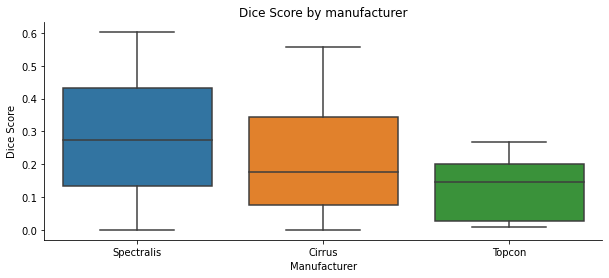

In [44]:
plt.figure(figsize=(10,4))
plt.title('Dice Score by manufacturer')
sns.boxplot(data=metrics_fluid, y='dice', x='manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Dice Score')
sns.despine()
plt.savefig(os.path.join(folder, 'dice.png'), bbox_inches='tight')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

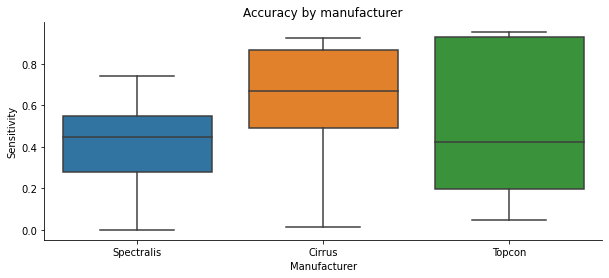

In [45]:
plt.figure(figsize=(10,4))
plt.title('Accuracy by manufacturer')
sns.boxplot(data=metrics_fluid, y='sens', x='manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Sensitivity')
sns.despine()
plt.savefig(os.path.join(folder, 'sensitivity.png'), bbox_inches='tight')

In [43]:
folder = '/home/joaquin/Desktop/MAIA/Clases/image-processing/project/image-processing-project/data/figures'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

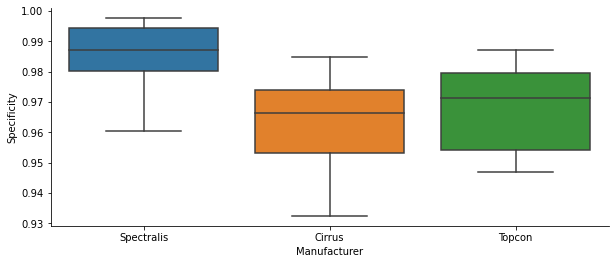

In [46]:
plt.figure(figsize=(10,4))
sns.boxplot(data=metrics_fluid, y='spec', x='manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Specificity')
sns.despine()
plt.savefig(os.path.join(folder, 'specificy.png'), bbox_inches='tight')